In [29]:
from importlib import reload
import torch
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

import data
reload(data)
from data import AmlsimDataset

import modules
reload(modules)
from modules import GCN, GCN_GNNExplainer
from modules import GraphSAGE
from torch_geometric.data import DataLoader
import torch.optim as optim


In [30]:
# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [31]:
# Load data
traindata = AmlsimDataset(node_file='data/simulation2/swedbank/train/nodes.csv', edge_file='data/simulation2/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
testdata = AmlsimDataset(node_file='data/simulation2/swedbank/test/nodes.csv', edge_file='data/simulation2/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()
traindata = traindata.to(device)
testdata = testdata.to(device)

# # Convert label tensors to one-hot encoded form
# traindata.y = F.one_hot(traindata.y, num_classes=2)
# testdata.y = F.one_hot(testdata.y, num_classes=2)

In [32]:
# Normalize data
mean = traindata.x.mean(dim=0, keepdim=True)
std = traindata.x.std(dim=0, keepdim=True)
traindata.x = (traindata.x - mean) / std
testdata.x = (testdata.x - mean) / std

In [33]:
# Instantiate model
input_dim = 10
hidden_dim = 16
output_dim = 2
n_layers = 3
dropout = 0.3
model = GCN_GNNExplainer(input_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

GCN_GNNExplainer(
  (convs): ModuleList(
    (0): GCNConv(10, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 2)
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (softmax): Softmax(dim=1)
)

In [34]:
print(model.output_dim)

2


In [35]:
# optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [36]:
# loss function
criterion = torch.nn.CrossEntropyLoss()

In [37]:
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model.forward(traindata.x, traindata.edge_index)
    loss = criterion(out, traindata.y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            out = model.forward(testdata.x, testdata.edge_index)
            loss = criterion(out, testdata.y)
            precision = precision_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            recall = recall_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            print(f'epoch: {epoch + 1}, loss: {loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')

epoch: 10, loss: 0.6717, precision: 0.4600, recall: 0.2771
epoch: 20, loss: 0.6393, precision: 0.6154, recall: 0.1928
epoch: 30, loss: 0.6007, precision: 0.7000, recall: 0.1265
epoch: 40, loss: 0.5734, precision: 0.8000, recall: 0.1446
epoch: 50, loss: 0.5586, precision: 0.8519, recall: 0.1386
epoch: 60, loss: 0.5508, precision: 0.8519, recall: 0.1386
epoch: 70, loss: 0.5455, precision: 0.8519, recall: 0.1386
epoch: 80, loss: 0.5431, precision: 0.8519, recall: 0.1386
epoch: 90, loss: 0.5407, precision: 0.8519, recall: 0.1386
epoch: 100, loss: 0.5385, precision: 0.8519, recall: 0.1386
epoch: 110, loss: 0.5370, precision: 0.8519, recall: 0.1386
epoch: 120, loss: 0.5359, precision: 0.8519, recall: 0.1386
epoch: 130, loss: 0.5347, precision: 0.8519, recall: 0.1386
epoch: 140, loss: 0.5345, precision: 0.8519, recall: 0.1386
epoch: 150, loss: 0.5323, precision: 0.8519, recall: 0.1386
epoch: 160, loss: 0.5320, precision: 0.8276, recall: 0.1446
epoch: 170, loss: 0.5307, precision: 0.8276, reca

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out = model.forward(testdata.x, testdata.edge_index)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)





[[395   5]
 [140  26]]


In [39]:
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer

data = testdata  # A homogeneous graph data object.

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

# Generate explanation for the node at index `10`:
explanation = explainer(data.x, data.edge_index, index=0)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

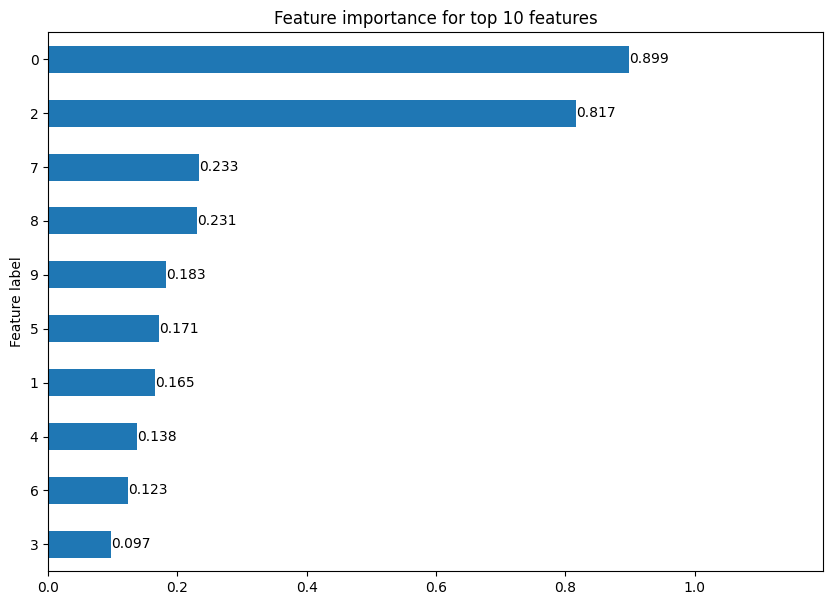

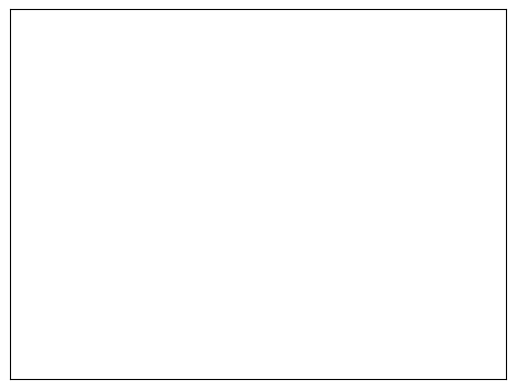

In [40]:
explanation.visualize_feature_importance(top_k=10)

explanation.visualize_graph()

In [41]:
from torch_geometric.explain import unfaithfulness

metric = unfaithfulness(explainer, explanation)
print(metric)

0.9134350344538689
